In [54]:
from collections import OrderedDict, defaultdict
from enum import Enum
from pathlib import Path
from typing import Any, Callable, Mapping, Optional, Union
import collections
import math
import random

import numpy as np
from numpy.random import RandomState

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataloader import default_collate

import matplotlib.pyplot as plt
from matplotlib.figure import Figure

# For CLIP embeddings
import clip

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.set_float32_matmul_precision('high')

# Todo
Layer by layer embedder that feeds into 2 layers in the model

# Diffusion Model
A model that generates layers of a voxelized 3D model one layer at a time through defusion.

The general idea of this is to do diffusion twice.

The first diffusion is done for each layer. Each layer goes through all diffusion time steps, and is combined at the end to be a 3D object.

This is done for x granularities of voxels, where each previous granularity informs the current granularity level.

In [55]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, channels, num_heads=8, dropout=0.2):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        
        num_groups = min(8, channels)
        while channels % num_groups != 0:
            num_groups -= 1
        self.norm = nn.GroupNorm(num_groups, channels)

        self.qkv = nn.Conv2d(channels, channels * 3, 1)  # 1x1 conv for Q, K, V
        self.proj = nn.Conv2d(channels, channels, 1)

        assert channels % num_heads == 0, f"channels {channels} must be divisible by num_heads {num_heads}"

        self.attn_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, C, H, W = x.shape
        
        # Normalize
        h = self.norm(x)
        
        # Get Q, K, V
        qkv = self.qkv(h)
        q, k, v = qkv.chunk(3, dim=1)
        
        # Reshape for multi-head attention
        q = q.view(B, self.num_heads, self.head_dim, H * W).transpose(2, 3)  # [B, heads, HW, head_dim]
        k = k.view(B, self.num_heads, self.head_dim, H * W).transpose(2, 3)
        v = v.view(B, self.num_heads, self.head_dim, H * W).transpose(2, 3)
        
        # Scaled dot-product attention
        scale = self.head_dim ** -0.5
        attn = torch.matmul(q, k.transpose(-2, -1)) * scale
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)
        
        # Apply attention to values
        out = torch.matmul(attn, v)  # [B, heads, HW, head_dim]
        out = out.transpose(2, 3).contiguous().view(B, C, H, W)
        
        # Project and add residual
        out = self.proj(out)
        return x + out
    

In [56]:
class MultiHeadCrossAttention(nn.Module):
    """
    A more standard implementation where context is properly projected 
    and can attend to multiple positions
    """
    def __init__(self, channels, context_dim, num_heads=8, context_tokens=8):
        super().__init__()
        self.channels = channels
        self.context_dim = context_dim
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        self.context_tokens = context_tokens

        self.norm = nn.GroupNorm(min(8, channels), channels)
        self.q = nn.Conv2d(channels, channels, 1)

        # Project context to key and value
        self.context_mlp_proj = nn.Sequential(
            nn.Linear(context_dim, context_dim * 2),
            nn.GELU(),
            nn.Linear(context_dim * 2, channels * self.context_tokens * 2)
        )
        
        # Final projection
        self.proj = nn.Conv2d(channels, channels, 1)

        self.context_pos_emb = nn.Parameter(
            torch.randn(1, self.context_tokens, channels) * 0.02
        )
        

        
    def forward(self, x, context):
        B, C, H, W = x.shape
        
        # Normalize spatial features
        h = self.norm(x)
        
        # Query from spatial features
        q = self.q(h)  # [B, C, H, W]
        q = q.view(B, self.num_heads, self.head_dim, H * W)
        q = q.permute(0, 1, 3, 2)  # [B, heads, HW, head_dim]
        
        # Project context to key and value
        context_proj = self.context_mlp_proj(context)  # [B, channels * context_tokens * 2]
        context_proj = context_proj.view(B, self.context_tokens, 2, self.channels)

        context_proj[:, :, 1] += self.context_pos_emb  # Add to V only  
        k, v = context_proj[:, :, 0], context_proj[:, :, 1]  # Each is [B, context_tokens, channels]
        
        # Add sequence dimension to k and v
        k = k.view(B, self.context_tokens, self.num_heads, self.head_dim)
        v = v.view(B, self.context_tokens, self.num_heads, self.head_dim)
        k = k.permute(0, 2, 1, 3)  # [B, heads, num_tokens, head_dim]
        v = v.permute(0, 2, 1, 3)  # [B, heads, num_tokens, head_dim]

        # Compute attention scores
        scale = self.head_dim ** -0.5
        scores = torch.matmul(q, k.transpose(-2, -1)) * scale  # [B, heads, HW, 1]
        attn = F.softmax(scores, dim=-1)
        
        # Apply attention 
        out = torch.matmul(attn, v)
        
        # Reshape back to spatial dimensions
        out = out.permute(0, 1, 3, 2).contiguous()  # [B, heads, head_dim, HW]
        out = out.view(B, C, H, W)
        
        # Final projection and residual
        out = self.proj(out)
        return x + out

In [57]:
class TransformerBlock(nn.Module):
    def __init__(self, channels, context_dim, num_heads=8, dropout=0.2):
        super().__init__()
        self.self_attn = MultiHeadSelfAttention(channels, num_heads, dropout)
        self.cross_attn = MultiHeadCrossAttention(channels, context_dim, num_heads)

        num_groups = min(8, channels)
        while channels % num_groups != 0:
            num_groups -= 1
    

        self.ffn = nn.Sequential(
            nn.GroupNorm(num_groups, channels),
            nn.Conv2d(channels, channels * 4, 1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(channels * 4, channels, 1),
            nn.Dropout(dropout)
        )


    def forward(self, x, context):
        x = self.self_attn(x)
        x = self.cross_attn(x, context)
        return x + self.ffn(x)



In [ ]:

# Using sinusoidal positional embeddings for time steps
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        if self.dim % 2 == 1:  # zero pad
            emb = F.pad(emb, (0,1,0,0))
        return emb


# Enhanced ResNet Block with optional attention
class ResnetBlockWithAttention(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, context_dim, layer_context_dim = 64, use_attention=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_channels)

        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_channels)

        self.layer_mlp = nn.Sequential(
            nn.Linear(layer_context_dim, out_channels),
            nn.SiLU(),
            nn.Linear(out_channels, out_channels)
        ) 

        self.activation = nn.SiLU()
        
        # Add transformer block if specified
        self.use_attention = use_attention
        if use_attention:
            self.attention = TransformerBlock(out_channels, context_dim, num_heads=8)

        # Shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x, t, context_emb, layer_context=None):
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.activation(h)
        
        # Add time embedding
        h += self.time_mlp(t)[:, :, None, None]

        # Add layer context if provided
        if layer_context is not None:
            h += self.layer_mlp(layer_context)[:, :, None, None]

        h = self.activation(h)
        h = self.conv2(h)
        h = self.norm2(h)
        h = self.activation(h)
        
        # Apply attention if enabled
        if self.use_attention:
            h = self.attention(h, context_emb) # eventually add layer_context here too
        
        return h + self.shortcut(x)


class UNet(nn.Module):
    def __init__(self, in_channels=1, model_channels=128, context_dim=512, 
                 attention_resolutions=[8, 16]):
        """
        attention_resolutions: list of resolutions (H, W) where attention should be applied
        For 32x32 images: resolution 16 means we apply attention at 16x16 feature maps
        """
        super().__init__()
        self.model_channels = model_channels
        self.attention_resolutions = attention_resolutions
        
        # Time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            SinusoidalPosEmb(model_channels),
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # Input
        self.input_conv = nn.Conv2d(in_channels, model_channels, 3, padding=1)
        
        # Down blocks with attention at specific resolutions
        # For 32x32 input: 32 -> 16 -> 8
        self.down_block1 = ResnetBlockWithAttention(
            model_channels, model_channels * 2, time_embed_dim, context_dim,
            use_attention=(32 in attention_resolutions)
        )
        self.down_block2 = ResnetBlockWithAttention(
            model_channels * 2, model_channels * 4, time_embed_dim, context_dim,
            use_attention=(16 in attention_resolutions)
        )
        self.down_block3 = ResnetBlockWithAttention(
            model_channels * 4, model_channels * 4, time_embed_dim, context_dim,
            use_attention=(8 in attention_resolutions)
        )
        
        self.downsample1 = nn.MaxPool2d(2)
        self.downsample2 = nn.MaxPool2d(2)
        
        # Middle block with attention (always at lowest resolution)
        self.mid_block = ResnetBlockWithAttention(
            model_channels * 4, model_channels * 4, time_embed_dim, context_dim,
            use_attention=True
        )
        
        # Up blocks with attention
        self.up_block1 = ResnetBlockWithAttention(
            model_channels * 4, model_channels * 4, time_embed_dim, context_dim,
            use_attention=(8 in attention_resolutions)
        )
        self.up_block2 = ResnetBlockWithAttention(
            model_channels * 4 + model_channels * 4, model_channels * 2, time_embed_dim, context_dim,
            use_attention=(16 in attention_resolutions)
        )
        self.up_block3 = ResnetBlockWithAttention(
            model_channels * 2 + model_channels * 2, model_channels, time_embed_dim, context_dim,
            use_attention=(32 in attention_resolutions)
        )
        
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        
        # Output
        self.output_conv = nn.Conv2d(model_channels, in_channels, 3, padding=1)

    def forward(self, x, t, context, layer_context=None):
        # Time embedding
        time_emb = self.time_embed(t)

        # Input
        h = self.input_conv(x)

        # Downsampling with skip connections
        h1 = self.down_block1(h, time_emb, context)
        h = self.downsample1(h1)
        h2 = self.down_block2(h, time_emb, context)
        h = self.downsample2(h2)
        h3 = self.down_block3(h, time_emb, context)

        # Middle
        h = self.mid_block(h3, time_emb, context)

        # Upsampling with skip connections
        h = self.up_block1(h, time_emb, context)
        h = self.upsample1(h)
        h = torch.cat([h, h2], dim=1)
        h = self.up_block2(h, time_emb, context)
        h = self.upsample2(h)
        h = torch.cat([h, h1], dim=1)
        h = self.up_block3(h, time_emb, context)

        # Output
        return self.output_conv(h)



class ExponentialMovingAverage:
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

        # Initialize shadow weights
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        # Backup current parameters
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}


In [59]:
# forward diffusion that creates a corrupted input
class ForwardDiffusion():
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.timesteps = timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        
        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1.0 - self.betas
        self.alpha_hats = torch.cumprod(self.alphas, dim=0)

        # Precompute sqrt_alpha_hats and sqrt_one_minus_alpha_hats for efficiency
        self.sqrt_alpha_hats = torch.sqrt(self.alpha_hats)
        self.sqrt_one_minus_alpha_hats = torch.sqrt(1 - self.alpha_hats)

        # ensure all tensors are on the same device
        self.betas = self.betas.to(device)
        self.alphas = self.alphas.to(device)
        self.alpha_hats = self.alpha_hats.to(device)
        self.sqrt_alpha_hats = self.sqrt_alpha_hats.to(device)
        self.sqrt_one_minus_alpha_hats = self.sqrt_one_minus_alpha_hats.to(device)

    def forward(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        
        sqrt_alpha_hat = self.sqrt_alpha_hats[t].view(-1, 1, 1, 1).to(x0.device)
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alpha_hats[t].view(-1, 1, 1, 1).to(x0.device)
        
        xt = sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise
        return xt, noise

    def get_variance_schedule(self,t):
        # Return the variance at timestep t (posterior variance)

        if t == 0:
            return self.betas[0]
        else:
            alpha_hat_t = self.alpha_hats[t]
            alpha_hat_t_minus_1 = self.alpha_hats[t - 1]
            return self.betas[t] * (1 - alpha_hat_t_minus_1) / (1 - alpha_hat_t)


In [60]:
# Create a 2d difussion trainer
class DiffusionTrainer2D:
    def __init__(self, model, diffusion, scheduler):
        self.model = model # this is the noise predicting model (denoiser)
        self.diffusion = diffusion # this is the forward diffusion process (noise addition)

        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        self.scheduler = scheduler # can be None its the learning rate scheduler

    def train_step(self, x0, context):
        self.model.train()
        self.optimizer.zero_grad()

        batch_size = x0.size(0)
        t = torch.randint(0, self.diffusion.timesteps, (batch_size,), device=x0.device).long()
        xt, noise = self.diffusion.forward(x0, t)

        predicted_noise = self.model(xt, t.float(), context)
        loss = F.mse_loss(predicted_noise, noise)

        loss.backward()
        self.optimizer.step()

        if self.scheduler is not None:
            self.scheduler.step()

        return loss.item()
        
    def sample(self, context, shape, device):
        self.model.eval()
        with torch.no_grad():
            x = torch.randn(shape, device=device)
            for t in reversed(range(self.diffusion.timesteps)):
                t_batch = torch.full((shape[0],), t, device=device, dtype=torch.float32)
                predicted_noise = self.model(x, t_batch, context)

                alpha_t = self.diffusion.alphas[t]
                alpha_hat_t = self.diffusion.alpha_hats[t]
                beta_t = self.diffusion.betas[t]

                if t > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)

                x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)) * predicted_noise) + torch.sqrt(beta_t) * noise

            return x

In [61]:
class ExponentialMovingAverage:
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

        # Initialize shadow weights
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        # Backup current parameters
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}


In [62]:
from torchvision import datasets

# sample dataset of grayscale cifar10 images
class GrayscaleCIFAR10(Dataset):
    def __init__(self, root, train=True, transform=None, download=True):
        self.cifar10 = datasets.CIFAR10(root=root, train=train, transform=transform, download=download)

    def __len__(self):
        return len(self.cifar10)

    def __getitem__(self, idx):
        img, label = self.cifar10[idx]
        # Convert to grayscale
        img = img.convert("L")
        img = np.array(img).astype(np.float32) / 255.0  # Normalize to [0, 1]
        img = torch.from_numpy(img).unsqueeze(0)  # Add channel dimension
        return img, label


In [63]:
dataloader = DataLoader(GrayscaleCIFAR10(root='./data'), batch_size=64, shuffle=True, num_workers=4)

/home/ad.msoe.edu/benzshawelt/Kedziora/kedziora_research/.conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Total parameters: 80,552,065
Epoch 1/10, Average Loss: 0.0896
Epoch 2/10, Average Loss: 0.0341
Epoch 3/10, Average Loss: 0.0318
Epoch 4/10, Average Loss: 0.0303
Epoch 5/10, Average Loss: 0.0301


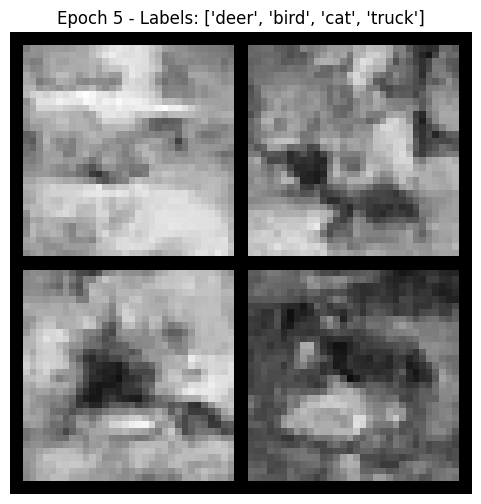

Epoch 6/10, Average Loss: 0.0292
Epoch 7/10, Average Loss: 0.0288
Epoch 8/10, Average Loss: 0.0288
Epoch 9/10, Average Loss: 0.0281
Epoch 10/10, Average Loss: 0.0283


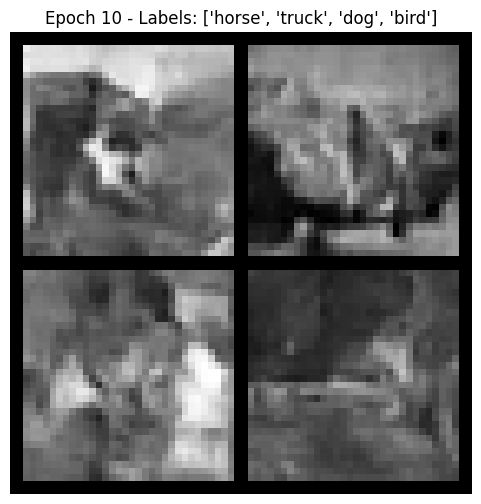

In [ ]:
import torchvision

diffusion = ForwardDiffusion(timesteps=1000, beta_start=1e-4, beta_end=0.02)

# Attention is applied at resolutions 8 and 16 (for 32x32 images)
unet = UNet(
    in_channels=1, 
    model_channels=128, 
    context_dim=512, 
    attention_resolutions=[8, 16]  # Apply attention at 8x8 and 16x16 feature maps
).to(device)

# Calculate and print model parameters
total_params = sum(p.numel() for p in unet.parameters())
print(f"Total parameters: {total_params:,}")

trainer = DiffusionTrainer2D(unet, diffusion, scheduler=None)
n_epochs = 10

use_ema = True

if use_ema:
    ema_model = ExponentialMovingAverage(unet, decay=0.999)

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

for epoch in range(n_epochs):
    epoch_loss = 0
    num_batches = 0
    
    for x0, label in dataloader:
        x0 = x0.to(device)

        # Get context embeddings from CLIP
        with torch.no_grad():
            text_inputs = torch.cat([clip.tokenize(f"a photo of a {dataloader.dataset.cifar10.classes[l]}") for l in label]).to(device)
            context = clip_model.encode_text(text_inputs).float()

        loss = trainer.train_step(x0, context)
        epoch_loss += loss
        num_batches += 1
        
        if use_ema:
            ema_model.update()
    
    avg_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1}/{n_epochs}, Average Loss: {avg_loss:.4f}")

    # Sample and visualize
    if (epoch + 1) % 5 == 0:  
        if use_ema:
            ema_model.apply_shadow()
        
        # Grab random labels and get their context embeddings
        with torch.no_grad():
            random_labels = random.choices(range(10), k=4)
            text_inputs = torch.cat([clip.tokenize(f"a photo of a {dataloader.dataset.cifar10.classes[l]}") for l in random_labels]).to(device)
            sample_context = clip_model.encode_text(text_inputs).float()

            samples = trainer.sample(sample_context, shape=(4, 1, 32, 32), device=device)
            samples = samples.clamp(0, 1).cpu()
            grid = torchvision.utils.make_grid(samples, nrow=2)
            
            plt.figure(figsize=(6, 6))
            plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
            plt.title(f'Epoch {epoch+1} - Labels: {[dataloader.dataset.cifar10.classes[l] for l in random_labels]}')
            plt.axis('off')
            plt.show()
            
        if use_ema:
            ema_model.restore()



# Now that we have a 2D diffusion model, we need to make a wrapper around the model to generate layers of the same object

In [ ]:
# 2D diffusion model wrapper for generating layers of the same object

# the layer context dim is the dimension of the input that describes the previous layer
# the granularity is the number of layers to generate and also the resolution of the unet input and output, so if we do positional encoding of the layer index, it will be in range(0, granularity)
class LayerXLayerDiffusionModel(nn.Module):
    def __init__(self, base_model: UNet, layer_context_dim=64, granularity=128, layer_by_layer_convergence=True):
        """
        Wrapper for the 2D diffusion model to generate layers of the same object.
        """
        super().__init__()
        self.base_model = base_model  # This is the 2D diffusion model (UNet)
        self.layer_context_dim = layer_context_dim  # Dimension of the layer context input
        self.granularity = granularity  # (number of layers to generate and also the resolution of the unet input and output)
        self.layer_by_layer_convergence = layer_by_layer_convergence  # Whether to run diffusion to convergence for each layer

        if self.layer_by_layer_convergence:
            # create the forward diffusion process for each layer
            self.layer_diffusion = ForwardDiffusion(timesteps=1000, beta_start=1e-4, beta_end=0.02)
            

        # Additional transformer block to integrate previous layer information

        # I want to give positional encoding to the layer context as well (what layer it currently is out of the granularity) this can change
        self.layer_positional_encoding = SinusoidalPosEmb(layer_context_dim)

        self.layer_transformer = TransformerBlock(
            channels=base_model.model_channels, 
            context_dim=layer_context_dim,
            num_heads=8
        )

    def forward(self, x, t, l, context, prev_layer_features):
        # x is the current layer input (noisy)
        # t is the current timestep
        # l is the current layer index (0 to granularity-1)
        # context is the global context (e.g. CLIP embedding)
        # prev_layer_features is the features from the previous layer (None if first layer) 
        # Integrate previous layer features using transformer
        if prev_layer_features is not None:
            prev_layer_features = self.layer_transformer(prev_layer_features, context)
        
        layer_context = prev_layer_features if prev_layer_features is not None else torch.zeros_like(x)
        layer_context += self.layer_positional_encoding(l.float())

        # run full diffusion on this layer until convergence
        if self.layer_by_layer_convergence:
            # run the diffusion process for this layer until convergence
            # this means we need to run the diffusion process for this layer until the noise is very low
            batch_size = x.size(0)
            for step in reversed(range(self.layer_diffusion.timesteps)):
                t_layer = torch.full((batch_size,), step, device=x.device, dtype=torch.float32)
                predicted_noise = self.base_model(x, t_layer, context, layer_context)

                alpha_t = self.layer_diffusion.alphas[step]
                alpha_hat_t = self.layer_diffusion.alpha_hats[step]
                beta_t = self.layer_diffusion.betas[step]

                if step > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)

                base_out = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)) * predicted_noise) + torch.sqrt(beta_t) * noise
        
        else:
            # otherwise we run a single step of diffusion for this layer, and outside of the class, we run the full diffusion process for all layers at once
            base_out = self.base_model(x, t, context, layer_context)

        return base_out, layer_context

In [ ]:
# create the 3d voxel dataset (inside the folder_path_{granularity}, there are .npy files of shape (granularity, granularity, granularity) with values in [0, 1])
# the user will make a voxel dataset object for each granularity they want to train on
class VoxelDataset(Dataset):
    def __init__(self, npy_folder_path, description_folder_path, transform=None, granularity=128):
        self.npy_folder_path = npy_folder_path
        self.description_folder_path = description_folder_path
        self.transform = transform
        self.granularity = granularity
       
        self.file_list = list(Path(npy_folder_path).glob("*.npy"))
        assert len(self.file_list) > 0, f"No .npy files found in {npy_folder_path}"

        self.descriptions = {}
        for desc_file in Path(description_folder_path).glob("*.txt"):
            key = desc_file.stem  # filename without extension
            with open(desc_file, 'r') as f:
                self.descriptions[key] = f.read().strip()


    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        voxel_grid = np.load(self.file_list[idx]).astype(np.float32)  # shape (granularity, granularity, granularity)
        assert voxel_grid.shape == (self.granularity, self.granularity, self.granularity), f"Voxel grid shape {voxel_grid.shape} does not match expected shape {(self.granularity, self.granularity, self.granularity)}"
        
        if self.transform:
            voxel_grid = self.transform(voxel_grid)
        
        voxel_grid = torch.from_numpy(voxel_grid).unsqueeze(0)  # Add channel dimension -> shape (1, granularity, granularity, granularity)

        filename_key = self.file_list[idx].stem
        description = self.descriptions.get(filename_key, "A 3D object")  # Default description if not found
        return voxel_grid, description

In [ ]:
# create a 3d difussion trainer for the layer x layer model

class LayerXLayerDiffusionTrainer:
    def __init__(self, model: LayerXLayerDiffusionModel, diffusion: ForwardDiffusion, scheduler, layer_by_layer_convergence=True):
        self.model = model  # this is the layer x layer diffusion model
        self.diffusion = diffusion  # this is the forward diffusion process (noise addition)

        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        self.scheduler = scheduler  # can be None its the learning rate scheduler
        self.layer_by_layer_convergence = layer_by_layer_convergence

    def train_step(self, x0, context):
        """
        x0: [B, C, H, W] the full object with all layers
        context: [B, context_dim] the global context (e.g. CLIP embedding)
        """
        self.model.train()
        self.optimizer.zero_grad()

        batch_size = x0.size(0)
        device = x0.device

        # Initialize previous layer features to None
        prev_layer_features = None

        total_loss = 0

        # Iterate over each layer
        for layer_idx in range(self.model.granularity):
            # Extract the current layer from x0
            current_layer = x0[:, :, :, layer_idx]  # [B, C, H, W-layer_idx]

            # Randomly sample a timestep for this layer
            t = torch.randint(0, self.diffusion.timesteps, (batch_size,), device=device).long()

            # Add noise to the current layer
            xt, noise = self.diffusion.forward(current_layer, t)

            # Create a tensor for the current layer index
            l = torch.full((batch_size,), layer_idx, device=device, dtype=torch.float32)

            # Predict noise using the model
            predicted_noise, prev_layer_features = self.model(xt, t.float(), l, context, prev_layer_features)

            # Compute loss for this layer
            loss = F.mse_loss(predicted_noise, noise)
            total_loss += loss

        # Backpropagate and optimize
        total_loss.backward()
        self.optimizer.step()

        if self.scheduler is not None:
            self.scheduler.step()

        avg_loss = total_loss.item() / self.model.granularity
        return avg_loss


    def layer_convergence_sample(self, context, shape, device):
        """
        context: [B, context_dim] the global context (e.g. CLIP embedding)
        shape: (B, C, H, W) the shape of each layer to generate
        """
        self.model.eval()
        with torch.no_grad():
            batch_size = shape[0]
            prev_layer_features = None

            # Initialize an empty voxel grid
            voxel_grid = torch.zeros((batch_size, shape[1], shape[2], self.model.granularity), device=device)

            for layer_idx in range(self.model.granularity):
                # Create a tensor for the current layer index
                l = torch.full((batch_size,), layer_idx, device=device, dtype=torch.float32)

                # Start with pure noise for this layer
                x = torch.randn(shape, device=device)

                # Run diffusion to convergence for this layer
                for t in reversed(range(self.diffusion.timesteps)):
                    t_batch = torch.full((batch_size,), t, device=device, dtype=torch.float32)
                    predicted_noise, prev_layer_features = self.model(x, t_batch, l, context, prev_layer_features)

                    alpha_t = self.diffusion.alphas[t]
                    alpha_hat_t = self.diffusion.alpha_hats[t]
                    beta_t = self.diffusion.betas[t]

                    if t > 0:
                        noise = torch.randn_like(x)
                    else:
                        noise = torch.zeros_like(x)

                    x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)) * predicted_noise) + torch.sqrt(beta_t) * noise

                # Place the generated layer into the voxel grid
                voxel_grid[:, :, :, layer_idx] = x.squeeze(1)  # Remove channel dimension

            return voxel_grid.clamp(0, 1)  # Return the full voxel grid
        
    def object_convergence_sample(self, context, shape, device):
        """
        context: [B, context_dim] the global context (e.g. CLIP embedding)
        shape: (B, C, H, W) the shape of each layer to generate
        """
        self.model.eval()
        with torch.no_grad():
            batch_size = shape[0]
            device = context.device

            # Initialize an empty voxel grid
            voxel_grid = torch.zeros((batch_size, shape[1], shape[2], self.model.granularity), device=device)

            # Start with pure noise for the entire object
            x = torch.randn((batch_size, shape[1], shape[2], self.model.granularity), device=device)

            # Randomly sample a timestep for the entire object
            t = torch.randint(0, self.diffusion.timesteps, (batch_size,), device=device).long()

            # Initialize previous layer features to None
            prev_layer_features = None

            for layer_idx in range(self.model.granularity):
                # Create a tensor for the current layer index
                l = torch.full((batch_size,), layer_idx, device=device, dtype=torch.float32)

                # Extract the current layer from x
                current_layer = x[:, :, :, layer_idx]  # [B, C, H, W-layer_idx]

                # Predict noise using the model
                predicted_noise, prev_layer_features = self.model(current_layer, t.float(), l, context, prev_layer_features)

                alpha_t = self.diffusion.alphas[t]
                alpha_hat_t = self.diffusion.alpha_hats[t]
                beta_t = self.diffusion.betas[t]

                if layer_idx < self.model.granularity - 1:
                    noise = torch.randn_like(current_layer)
                else:
                    noise = torch.zeros_like(current_layer)

                # Update the current layer in x
                x[:, :, :, layer_idx] = (1 / torch.sqrt(alpha_t)) * (current_layer - ((1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)) * predicted_noise) + torch.sqrt(beta_t) * noise

                # Place the updated layer into the voxel grid
                voxel_grid[:, :, :, layer_idx] = x[:, :, :, layer_idx]

            return voxel_grid.clamp(0, 1)  # Return the full voxel grid
        

In [ ]:
# train the layer x layer diffusion model

granularity = 32  # number of layers to generate and also the resolution of the unet input and output
layer_context_dim = 64  # dimension of the layer context input
layer_by_layer_convergence = True  # Whether to run diffusion to convergence for each layer
layer_diffusion = ForwardDiffusion(timesteps=1000, beta_start=1e-4, beta_end=0.02)

layer_x_layer_model = LayerXLayerDiffusionModel(
    base_model=unet,
    layer_context_dim=layer_context_dim,
    granularity=granularity,
    layer_by_layer_convergence=layer_by_layer_convergence
).to(device)

scheduler = None

layer_x_layer_trainer = LayerXLayerDiffusionTrainer(
    model=layer_x_layer_model,
    diffusion=layer_diffusion,
    scheduler=scheduler,
    layer_by_layer_convergence=layer_by_layer_convergence
)

import clip
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()
dataloader_3d = DataLoader(VoxelDataset(
    npy_folder_path=f'./data/voxels_{granularity}', 
    description_folder_path='./data/descriptions', 
    granularity=granularity
), batch_size=4, shuffle=True, num_workers=4)


n_epochs_3d = 10
use_ema_3d = True
if use_ema_3d:
    ema_model_3d = ExponentialMovingAverage(layer_x_layer_model, decay=0.999)



for epoch in range(n_epochs_3d):
    epoch_loss = 0
    num_batches = 0
    
    for x0, description in dataloader_3d:
        x0 = x0.to(device)  # [B, 1, H, W, D]

        # Get context embeddings from CLIP
        with torch.no_grad():
            text_inputs = torch.cat([clip.tokenize(desc) for desc in description]).to(device)
            context = clip_model.encode_text(text_inputs).float()

        loss = layer_x_layer_trainer.train_step(x0, context)
        epoch_loss += loss
        num_batches += 1
        
        if use_ema_3d:
            ema_model_3d.update()
    
    avg_loss = epoch_loss / num_batches
    print(f"3D Epoch {epoch+1}/{n_epochs_3d}, Average Loss: {avg_loss:.4f}")

    # Sample and visualize
    if (epoch + 1) % 5 == 0:  
        if use_ema_3d:
            ema_model_3d.apply_shadow()
        
        # Grab random descriptions and get their context embeddings
        with torch.no_grad():
            random_descriptions = random.choices(list(dataloader_3d.dataset.descriptions.values()), k=2)
            text_inputs = torch.cat([clip.tokenize(desc) for desc in random_descriptions]).to(device)
            sample_context = clip_model.encode_text(text_inputs).float()

            samples = layer_x_layer_trainer.layer_convergence_sample(
                sample_context, 
                shape=(2, 1, granularity, granularity), 
                device=device
            )  # [B, 1, H, W, D]
            samples = samples.clamp(0, 1).cpu()

            # Visualize the middle slice of the voxel grid for each sample
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            for i in range(2):
                mid_slice = samples[i, 0, :, :, granularity // 2]  # Middle slice along depth
                axes[i].imshow(mid_slice, cmap='gray')
                axes[i].set_title(f'Sample {i+1}\n"{random_descriptions[i][:30]}..."')
                axes[i].axis('off')
            plt.show()
            
        if use_ema_3d:
            ema_model_3d.restore